In [99]:
import os
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
import util
import json

import warnings
warnings.filterwarnings("ignore")

In [100]:
project = hopsworks.login(project="dbillLab1")
fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1169559
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


In [101]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)

We do a left join - if we used an inner join then we won't get back any row with a label

In [102]:
selected_features = air_quality_fg.select(['pm25', 'pm25_1_day_before','pm25_2_days_before','pm25_3_days_before', 'pm25_average_before']).join(weather_fg.select_all(), on=['city'])
selected_features.show(10)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.43s) 


,pm25,pm25_1_day_before,pm25_2_days_before,pm25_3_days_before,pm25_average_before,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,26.0,23.0,14.0,55.0,30.666666,2018-04-12 00:00:00+00:00,3.076917,0.0,14.241629,69.392525,stockholm
1,33.0,26.0,23.0,14.0,21.000000,2018-04-13 00:00:00+00:00,4.774834,0.0,15.273505,83.423416,stockholm
2,37.0,33.0,26.0,23.0,27.333334,2018-04-14 00:00:00+00:00,6.439417,0.0,12.496719,86.741173,stockholm
3,64.0,37.0,33.0,26.0,32.000000,2018-04-15 00:00:00+00:00,6.806084,0.0,11.183201,167.039749,stockholm
4,70.0,64.0,37.0,33.0,44.666668,2018-04-16 00:00:00+00:00,7.947750,0.0,9.000000,253.767578,stockholm
5,53.0,70.0,64.0,37.0,57.000000,2018-04-17 00:00:00+00:00,8.876916,0.0,19.803272,275.834167,stockholm
6,48.0,53.0,70.0,64.0,62.333332,2018-04-18 00:00:00+00:00,9.233166,0.5,23.732710,277.998291,stockholm
7,34.0,48.0,53.0,70.0,57.000000,2018-04-19 00:00:00+00:00,11.166500,0.0,12.979984,285.674316,stockholm
8,46.0,34.0,48.0,53.0,45.000000,2018-04-20 00:00:00+00:00,15.716500,0.0,19.602652,257.680573,stockholm
9,27.0,46.0,34.0,48.0,42.666668,2018-04-21 00:00:00+00:00,11.343582,0.3,21.093050,299.149994,stockholm


In [103]:
feature_view = fs.get_or_create_feature_view(
    name='air_quality_fv',
    description="weather features with air quality as the target",
    version=1,
    labels=['pm25'],
    query=selected_features,
)

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1169559/fs/1160262/fv/air_quality_fv/version/1


In [104]:
def count_rows(df):
    print(len(df))
    cut_off=round(0.2*len(df))
    print(cut_off)
    test_date=df.loc[cut_off,'date']
    test_date=test_date.replace("/", "-")
    print(test_date)
    return test_date

df_count=pd.read_csv("data/stockholm-st eriksgatan 83-air-quality.csv")
start_date_test_data=count_rows(df_count)

2203
441
2023-8-6


In [106]:
test_start = datetime.strptime(start_date_test_data, "%Y-%m-%d")

In [107]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_start=test_start
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.29s) 


In [108]:
X_train

,pm25_1_day_before,pm25_2_days_before,pm25_3_days_before,pm25_average_before,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,23.0,14.0,55.0,30.666666,2018-04-12 00:00:00+00:00,3.076917,0.0,14.241629,69.392525,stockholm
1,26.0,23.0,14.0,21.000000,2018-04-13 00:00:00+00:00,4.774834,0.0,15.273505,83.423416,stockholm
2,33.0,26.0,23.0,27.333334,2018-04-14 00:00:00+00:00,6.439417,0.0,12.496719,86.741173,stockholm
3,37.0,33.0,26.0,32.000000,2018-04-15 00:00:00+00:00,6.806084,0.0,11.183201,167.039749,stockholm
4,64.0,37.0,33.0,44.666668,2018-04-16 00:00:00+00:00,7.947750,0.0,9.000000,253.767578,stockholm
...,...,...,...,...,...,...,...,...,...,...
1677,22.0,19.0,12.0,17.666666,2023-08-01 00:00:00+00:00,16.212332,5.0,16.992609,139.629059,stockholm
1678,10.0,22.0,19.0,17.000000,2023-08-02 00:00:00+00:00,16.985250,4.0,21.626984,185.181625,stockholm
1679,10.0,10.0,22.0,14.000000,2023-08-03 00:00:00+00:00,16.006083,6.8,19.799999,118.752876,stockholm
1680,18.0,10.0,10.0,12.666667,2023-08-04 00:00:00+00:00,16.801918,4.0,15.745627,295.249268,stockholm


In [109]:
X_test

,pm25_1_day_before,pm25_2_days_before,pm25_3_days_before,pm25_average_before,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
1682,20.0,16.0,18.0,18.000000,2023-08-06 00:00:00+00:00,16.408169,12.0,23.469128,44.330021,stockholm
1683,23.0,20.0,16.0,19.666666,2023-08-07 00:00:00+00:00,19.356085,13.2,18.043148,106.957054,stockholm
1684,43.0,23.0,20.0,28.666666,2023-08-08 00:00:00+00:00,15.664416,4.9,30.903435,162.897202,stockholm
1685,6.0,43.0,23.0,24.000000,2023-08-09 00:00:00+00:00,14.070664,4.0,25.582806,161.041077,stockholm
1686,10.0,6.0,43.0,19.666666,2023-08-10 00:00:00+00:00,13.039417,7.5,16.099689,170.896332,stockholm
...,...,...,...,...,...,...,...,...,...,...
2132,10.0,29.0,19.0,19.333334,2024-11-11 00:00:00+00:00,4.908166,1.1,9.676569,234.773972,stockholm
2133,20.0,10.0,29.0,19.666666,2024-11-12 00:00:00+00:00,3.070667,0.0,10.990322,288.903290,stockholm
2134,21.0,20.0,10.0,17.000000,2024-11-13 00:00:00+00:00,3.472750,0.0,15.124284,238.321777,stockholm
2135,21.0,21.0,20.0,20.666666,2024-11-13 00:00:00+00:00,3.472750,0.0,15.124284,238.321777,stockholm


In [110]:
train_features= X_train.drop(['date', 'city'], axis=1)
test_features = X_test.drop(['date', 'city'], axis=1)

In [111]:
y_train

,pm25
0,26.0
1,33.0
2,37.0
3,64.0
4,70.0
...,...
1677,10.0
1678,10.0
1679,18.0
1680,16.0


In [112]:
xgb_regressor = XGBRegressor()
xgb_regressor.fit(train_features, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [113]:
y_pred= xgb_regressor.predict(test_features)

mse= mean_squared_error(y_test.iloc[:,0], y_pred)
print("MSE:", mse)

r2 = r2_score(y_test.iloc[:,0], y_pred)
print("R squared:", r2)

MSE: 70.70973
R squared: 0.45771896839141846


Storing predicted log

In [114]:
df = y_test
df['predicted_pm25'] = y_pred

In [115]:
df['date']= X_test['date']
df= df.sort_values(by=['date'])
df.head(5)

,pm25,predicted_pm25,date
1682,23.0,15.867196,2023-08-06 00:00:00+00:00
1683,43.0,32.334736,2023-08-07 00:00:00+00:00
1684,6.0,41.716927,2023-08-08 00:00:00+00:00
1685,10.0,7.266566,2023-08-09 00:00:00+00:00
1686,8.0,17.468176,2023-08-10 00:00:00+00:00


In [116]:
model_dir="air_quality_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir=model_dir+"/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

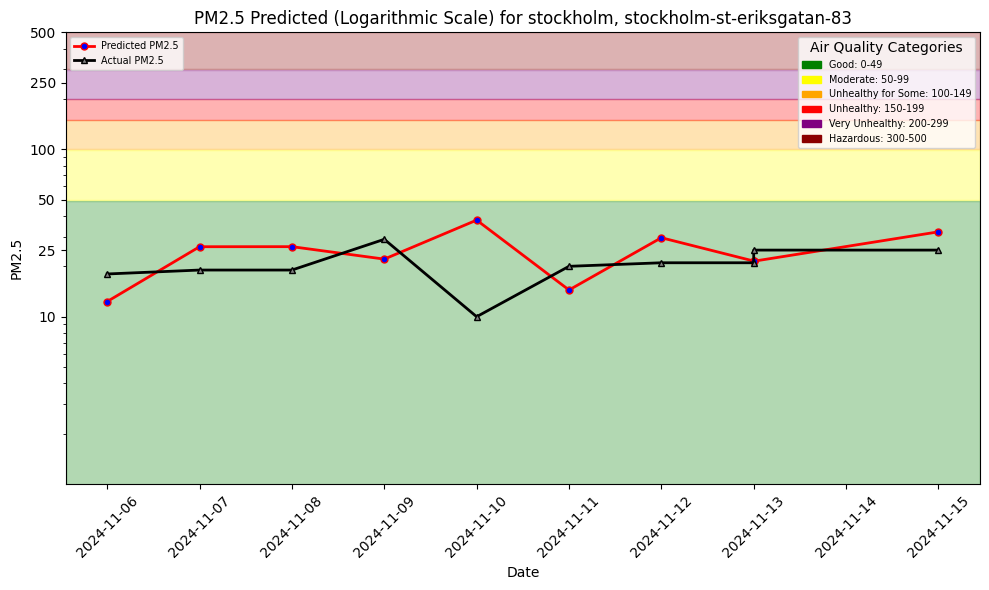

In [117]:
file_path=images_dir+"/pm25_hindcast.png"
plt=util.plot_air_quality_forecast(city, street, df.tail(10), file_path, hindcast=True)
plt.show()

In [118]:
df.tail(6)

,pm25,predicted_pm25,date
2131,10.0,37.760265,2024-11-10 00:00:00+00:00
2132,20.0,14.441373,2024-11-11 00:00:00+00:00
2133,21.0,29.634756,2024-11-12 00:00:00+00:00
2134,21.0,21.506361,2024-11-13 00:00:00+00:00
2135,25.0,21.452707,2024-11-13 00:00:00+00:00
2136,25.0,32.139519,2024-11-15 00:00:00+00:00


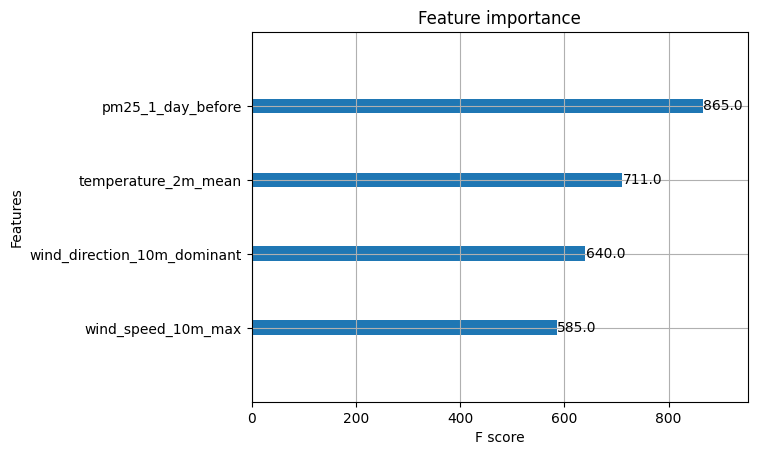

In [119]:
plot_importance(xgb_regressor, max_num_features=4)
feature_importance_path = images_dir + "/feature_importance.png"
plt.savefig(feature_importance_path)
plt.show()

In [120]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

# Creating input and output schemas using the 'Schema' class for features (X) and target variable (y)
input_schema = Schema(X_train)
output_schema = Schema(y_train)

# Creating a model schema using 'ModelSchema' with the input and output schemas
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

# Converting the model schema to a dictionary representation
schema_dict = model_schema.to_dict()

In [121]:
xgb_regressor.save_model(model_dir + "/model.json")

In [122]:
res_dict = { 
        "MSE": str(mse),
        "R squared": str(r2),
    }

In [123]:
mr = project.get_model_registry()

# Creating a Python model in the model registry named 'air_quality_xgboost_model'

aq_model = mr.python.create_model(
    name="air_quality_xgboost_model", 
    metrics= res_dict,
    model_schema=model_schema,
    input_example=X_test.sample().values, 
    description="Air Quality (PM2.5) predictor",
)

# Saving the model artifacts to the 'air_quality_model' directory in the model registry
aq_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/514626 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/18772 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/60973 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/161 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/969 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1169559/models/air_quality_xgboost_model/4


Model(name: 'air_quality_xgboost_model', version: 4)